In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

test_data_id = test_data.PassengerId

In [2]:
print(train_data.shape,test_data.shape)

(891, 12) (418, 11)


In [3]:
print(train_data.isnull().sum(),'\n\n',test_data.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64 

 PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [4]:
train_data.columns[train_data.dtypes!=object].tolist()

['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

In [5]:
train_data.columns[train_data.dtypes==object].tolist()

['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']

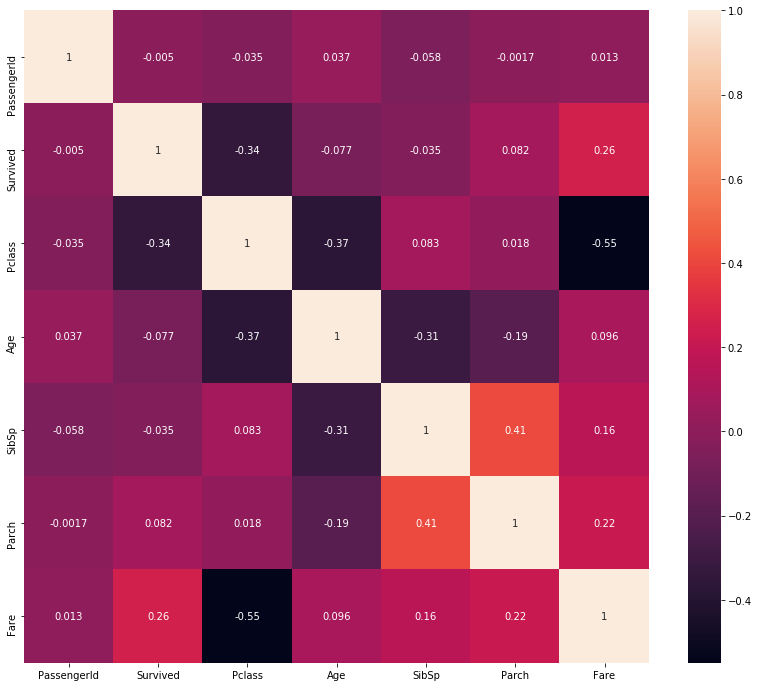

In [6]:
f, ax = plt.subplots(figsize=(14,12))
sns.heatmap(train_data.corr(), annot=True)

In [7]:
combined = [train_data,test_data]
# 对于训练集和测试集，都要一起进行数据处理

In [8]:
[ds.drop(labels='Ticket', inplace=True, axis=1) for ds in combined]
[ds.drop(labels='PassengerId', inplace=True, axis=1) for ds in combined]
# [ds.drop(labels='Cabin', inplace=True, axis=1) for ds in combined]

[None, None]

In [9]:
[ds.Embarked.fillna(ds.Embarked.mode()[0],inplace=True)for ds in combined]

[None, None]

In [10]:
train_data['Cabin'], test_data['Cabin'] = [[1 if x != 0 else 0 for x in ds['Cabin'].fillna(0)] for ds in combined]
combined = [train_data, test_data] # Same as before, we update combined

In [11]:
train_data['Title'], test_data['Title'] = [ds['Name'].str.extract(' ([A-Za-z]+)\.', expand=False) for ds in combined]
combined = [train_data, test_data]

[ds['Title'].replace(['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Ms'], 
                     'Other', inplace=True) for ds in combined]
[ds['Title'].replace(['Mme','Mlle','Dona'], 'Miss', inplace=True) for ds in combined]

[ds.drop(labels='Name', inplace=True, axis=1) for ds in combined]

[None, None]

In [12]:
train_data.groupby('Title')['Age'].mean()

Title
Master     4.574167
Miss      21.818792
Mr        32.368090
Mrs       35.898148
Other     44.782609
Name: Age, dtype: float64

In [13]:
# 对缺失值进行填补
train_data.loc[(train_data.Age.isnull())&(train_data.Title=='Master'),'Age']=4.5
train_data.loc[(train_data.Age.isnull())&(train_data.Title=='Mr'),'Age']=32.3
train_data.loc[(train_data.Age.isnull())&(train_data.Title=='Miss'),'Age']=21.8
train_data.loc[(train_data.Age.isnull())&(train_data.Title=='Mrs'),'Age']=35.8
train_data.loc[(train_data.Age.isnull())&(train_data.Title=='Other'),'Age']=44.7

test_data.loc[(test_data.Age.isnull())&(test_data.Title=='Master'),'Age']=4.5
test_data.loc[(test_data.Age.isnull())&(test_data.Title=='Mr'),'Age']=32.3
test_data.loc[(test_data.Age.isnull())&(test_data.Title=='Miss'),'Age']=21.8
test_data.loc[(test_data.Age.isnull())&(test_data.Title=='Mrs'),'Age']=35.8
test_data.loc[(test_data.Age.isnull())&(test_data.Title=='Other'),'Age']=44.7
#查看是否都填补好了
train_data.Age.isnull().any()

False

In [14]:
train_data['AgeBand'], test_data['AgeBand'] = [pd.cut(ds['Age'], bins=[0,20,45,60,120], labels=[1,2,3,4]) for ds in combined]
combined = [train_data, test_data]

[ds.drop(labels='Age', inplace=True, axis=1) for ds in combined]

[None, None]

In [15]:
train_data['FamilySize'], test_data['FamilySize'] = [ds['SibSp'] + ds['Parch'] +1 for ds in combined]
[ds.drop(['SibSp', 'Parch'], axis=1, inplace=True) for ds in combined]

[None, None]

In [16]:
[ds.Fare.fillna(ds['Fare'].median(), inplace=True) for ds in combined]

train_data['FareBand'], test_data['FareBand'] =[pd.cut(ds['Fare'], bins=5,labels=[1,2,3,4,5]) for ds in combined]

[ds.drop(['Fare'], axis=1, inplace=True) for ds in combined]

[None, None]

In [17]:
# One hot encoding these variables:
train_data, test_data = [pd.get_dummies(ds, columns=['Sex', 'Embarked','Pclass','Title']) for ds in combined]
combined = [train_data, test_data] # Dummies changes have been done in train and test, we must update combined
train_data.sample(5)

,Survived,AgeBand,FamilySize,FareBand,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Other
110,0,3,1,1,0,1,0,0,1,1,0,0,0,0,1,0,0
465,0,2,1,1,0,1,0,0,1,0,0,1,0,0,1,0,0
577,1,2,2,1,1,0,0,0,1,1,0,0,0,0,0,1,0
790,0,2,1,1,0,1,0,1,0,0,0,1,0,0,1,0,0
572,1,2,1,1,0,1,0,0,1,1,0,0,0,0,1,0,0


In [18]:
from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

# Cross validate model with Kfold stratified cross val
kfold = StratifiedKFold(n_splits=10)
Y_train = train_data["Survived"]
X_train = train_data.drop(labels = ["Survived"],axis = 1)

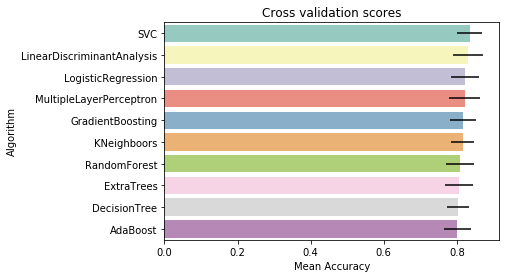

In [19]:
# Modeling step Test differents algorithms 
random_state = 2
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = Y_train, scoring = "accuracy", cv = kfold, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis"]})

cv_res=cv_res.sort_values('CrossValMeans',ascending=False)


g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

In [20]:
#  choose the SVC, AdaBoost, RandomForest , ExtraTrees
# and the GradientBoosting classifiers for the ensemble modeling.
### META MODELING  WITH ADABOOST, RF, EXTRATREES and GRADIENTBOOSTING

# Adaboost
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC, random_state=7)

ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[1,2],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}

gsadaDTC = GridSearchCV(adaDTC,param_grid = ada_param_grid, cv=kfold, scoring="accuracy", n_jobs=-1, verbose = 1)

gsadaDTC.fit(X_train,Y_train)

ada_best = gsadaDTC.best_estimator_

gsadaDTC.best_score_

Fitting 10 folds for each of 112 candidates, totalling 1120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 830 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 1120 out of 1120 | elapsed:    3.7s finished


0.8103745318352061

In [22]:
#ExtraTrees 
ExtC = ExtraTreesClassifier()


## Search grid for optimal parameters
ex_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsExtC = GridSearchCV(ExtC,param_grid = ex_param_grid, cv=kfold, scoring="accuracy", n_jobs=-1, verbose = 1)

gsExtC.fit(X_train,Y_train)

ExtC_best = gsExtC.best_estimator_

# Best score
gsExtC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 328 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:   19.9s finished


0.8305368289637952

In [23]:
# RFC Parameters tunning 
RFC = RandomForestClassifier()


## Search grid for optimal parameters
rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs=-1, verbose = 1)

gsRFC.fit(X_train,Y_train)

RFC_best = gsRFC.best_estimator_

# Best score
gsRFC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   10.7s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   26.1s
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:   32.5s finished


0.836167290886392

In [24]:
# Gradient boosting tunning

GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, scoring="accuracy", n_jobs= -1, verbose = 1)

gsGBC.fit(X_train,Y_train)

GBC_best = gsGBC.best_estimator_

# Best score
gsGBC.best_score_

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:   11.9s finished


0.8193258426966292

In [25]:
## SVC classifier
SVMC = SVC(probability=True)
svc_param_grid = {'kernel': ['rbf'], 
                  'gamma': [ 0.001, 0.01, 0.1, 1],
                  'C': [1, 10, 50, 100,200,300, 1000]}

gsSVMC = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=kfold, scoring="accuracy", n_jobs=-1, verbose = 1)

gsSVMC.fit(X_train,Y_train)

SVMC_best = gsSVMC.best_estimator_

# Best score
gsSVMC.best_score_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 257 out of 280 | elapsed:    5.0s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 280 out of 280 | elapsed:    6.0s finished


0.8361423220973784

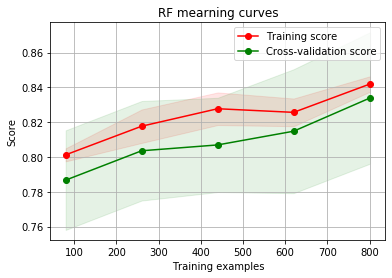

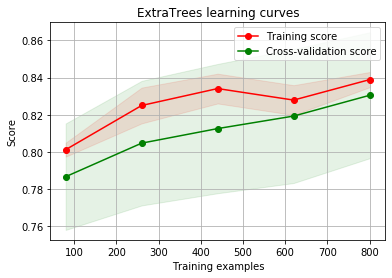

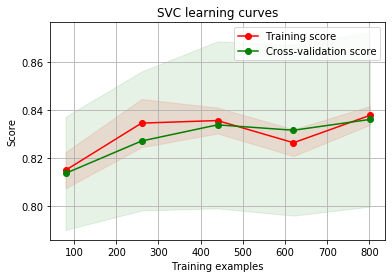

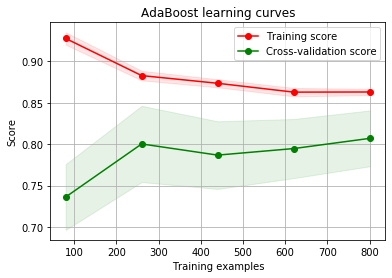

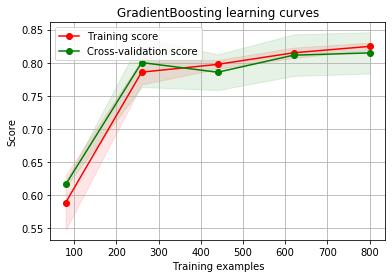

In [26]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

g = plot_learning_curve(gsRFC.best_estimator_,"RF mearning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsExtC.best_estimator_,"ExtraTrees learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsSVMC.best_estimator_,"SVC learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsadaDTC.best_estimator_,"AdaBoost learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsGBC.best_estimator_,"GradientBoosting learning curves",X_train,Y_train,cv=kfold)

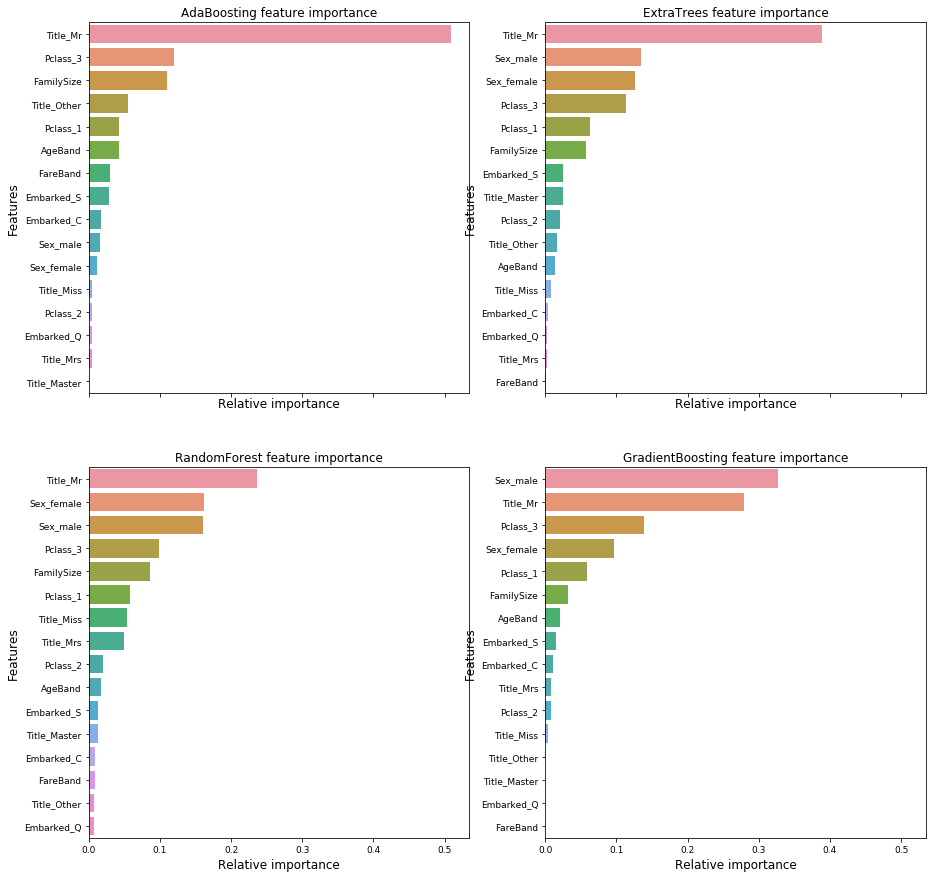

In [29]:
nrows = ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex="all", figsize=(15,15))

names_classifiers = [("AdaBoosting", ada_best),("ExtraTrees",ExtC_best),("RandomForest",RFC_best),("GradientBoosting",GBC_best)]

nclassifier = 0
for row in range(nrows):
    for col in range(ncols):
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:40]
        g = sns.barplot(y=X_train.columns[indices][:40],x = classifier.feature_importances_[indices][:40] , orient='h',ax=axes[row][col])
        g.set_xlabel("Relative importance",fontsize=12)
        g.set_ylabel("Features",fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name + " feature importance")
        nclassifier += 1

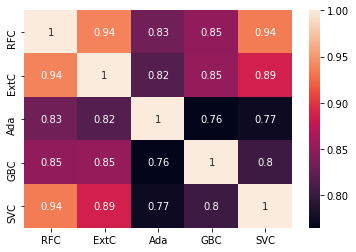

In [30]:
test_Survived_RFC = pd.Series(RFC_best.predict(test_data), name="RFC")
test_Survived_ExtC = pd.Series(ExtC_best.predict(test_data), name="ExtC")
test_Survived_SVMC = pd.Series(SVMC_best.predict(test_data), name="SVC")
test_Survived_AdaC = pd.Series(ada_best.predict(test_data), name="Ada")
test_Survived_GBC = pd.Series(GBC_best.predict(test_data), name="GBC")


# Concatenate all classifier results
ensemble_results = pd.concat([test_Survived_RFC,test_Survived_ExtC,test_Survived_AdaC,test_Survived_GBC, test_Survived_SVMC],axis=1)


g= sns.heatmap(ensemble_results.corr(),annot=True)

In [31]:
votingC = VotingClassifier(estimators=[('rfc', RFC_best), ('extc', ExtC_best),
('svc', SVMC_best), ('adac',ada_best),('gbc',GBC_best)], voting='soft', n_jobs=-1)

votingC = votingC.fit(X_train, Y_train)

In [33]:
# 生成csv文件
output = pd.DataFrame({'PassengerId': test_data_id, 'Survived':votingC.predict(test_data)})
output.to_csv('mySecondSubmission!.csv', index=False)
output.shape

(418, 2)

In [34]:
output

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
